# Holstein (semi-classical)

## Initialize variables and imports

In [2]:
import numpy
from scipy import linalg, special, integrate, optimize
from scipy.integrate import solve_ivp
import matplotlib
from matplotlib import pyplot
import gc

from tqdm.notebook import tqdm

import joblib

import born_markov as bmme

In [3]:
d_ops, d_dags = bmme.generate_fermionic_ops(1)
d1_op, d1_dag = d_ops[0], d_dags[0]

omega = .003
lamda = .02
epsilon = .15
Gamma = .005
Gammas = numpy.array([[[Gamma, Gamma]]])
T = .026 / bmme.k_B
voltage = 0.0

def func_H_s(x):
    H_s = .5 * (omega * x[0]**2) * numpy.identity(d1_op.shape[0])
    H_s += epsilon * d1_dag @ d1_op
    H_s += numpy.sqrt(2) * lamda * x[0] * d1_dag @ d1_op
    return H_s

def func_ddx_H_s(k, x):
    if k == 0:
        ddx = omega * x[0] * numpy.identity(d1_op.shape[0])
        ddx += numpy.sqrt(2) * lamda * d1_dag @ d1_op
        return ddx

## Calculate Langevin quantities

In [21]:
def my_func(i, val):
    return bmme.calc_langevin_quantities(func_H_s, func_ddx_H_s, val, d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, method="analytic", include_digamma=False)

#def my_func2(i, val):
#    solver = bmme.general_solver(func_H_s(val), d_ops, None, Gammas, -.5 * voltage, .5 * voltage, T, T, include_digamma=False)
#    r, L = solver.find_steady_state()
#    return solver.V @ r @ solver.V_dag

x1 = numpy.linspace(-1000, 1000, 4000001)
#x1 = numpy.linspace(-20, 10, 2000)

mean_force = numpy.zeros(len(x1), dtype=numpy.float64)
friction = numpy.zeros(len(x1), dtype=numpy.float64)
correlation = numpy.zeros(len(x1), dtype=numpy.float64)

results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func)(i, [val]) for i, val in enumerate(tqdm(x1)))

for i in range(len(results)):
    mean_force[i] = results[i][0].real
    friction[i] = results[i][1].real
    correlation[i] = results[i][2].real

numpy.save("data/holstein_semicl/mean_force_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array([x1, mean_force]))
numpy.save("data/holstein_semicl/friction_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array([x1, friction]))
numpy.save("data/holstein_semicl/correlation_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array([x1, correlation]))

## Load Langevin quantities and calculate PMF

In [20]:
import time

start = time.time()
friction0 = numpy.load("data/holstein_semicl/friction_" + str(lamda) + "_voltage_" + str(voltage) + ".npy")
mean_force0 = numpy.load("data/holstein_semicl/mean_force_" + str(lamda) + "_voltage_" + str(voltage) + ".npy")
correlation0 = numpy.load("data/holstein_semicl/correlation_" + str(lamda) + "_voltage_" + str(voltage) + ".npy")
print(time.time() - start)

grid = mean_force0[0]
force = mean_force0[1]
gamma = friction0[1]
corr = correlation0[1]
mbaoab_F = force / omega
mbaoab_gamma = gamma
mbaoab_sigma = numpy.sqrt(2 * corr / omega) #linalg.sqrtm(2 * corr)

def to_int_w_numpy_support(stuff):
    if isinstance(stuff, numpy.ndarray):
        return numpy.array(stuff, dtype=int)
    else:
        return int(stuff)

def get_lin_int(x, X):
    index_low = grid[0]
    index_high = grid[-1]
    index_l = to_int_w_numpy_support((x - index_low) * len(grid) / (index_high - index_low))
    index_h = index_l + 1
    x_1 = grid[index_l]
    x_2 = grid[index_h]
    
    x_target = x
    
    return (X[index_l] * (x_2 - x_target) + X[index_h] * (x_target - x_1)) / (x_2 - x_1)

def solve_mbaoab(x_0, v_0, N, dt=1e-2, K=10):
    factor = numpy.sqrt(dt / K)
    x = numpy.zeros(N+1)
    v = numpy.zeros(N+1)
    x[0] = x_0
    v[0] = v_0
    for i in tqdm(range(N)):
        x[i+1] = x[i] + 0.5 * dt * v[i]
        F = get_lin_int(x[i+1], mbaoab_F)
        gam = get_lin_int(x[i+1], mbaoab_gamma)
        sigma = get_lin_int(x[i+1], mbaoab_sigma)
        v[i+1] = v[i] + 0.5 * dt * F
        G = numpy.exp(-dt * gam / (2 * K))
        for j in range(K):
            v[i+1] = G * G * v[i+1] + factor * G * sigma * numpy.random.randn(1)
        v[i+1] += 0.5 * dt * F
        x[i+1] += 0.5 * dt * v[i+1]
    return x, v

pmf = numpy.zeros(len(grid), dtype=numpy.float64)
pmf_factor = (grid[-1] - grid[0]) / (len(grid) - 1)
for i in tqdm(range(1, len(grid))):
    pmf[i] = pmf[i-1] - (force[i] * pmf_factor)
min_arg = numpy.argmin(pmf)
print(grid[min_arg])
pmf /= omega
pmf -= numpy.amin(pmf)
#pmf += .5 * grid[0]**2 + epsilon/omega + numpy.sqrt(2)*lamda/omega * grid[0]

print(grid[numpy.argmin(numpy.abs(force))])

0.052000999450683594



-0.03049999999996089
-9.308999999999969


## Plot Langevin quantities

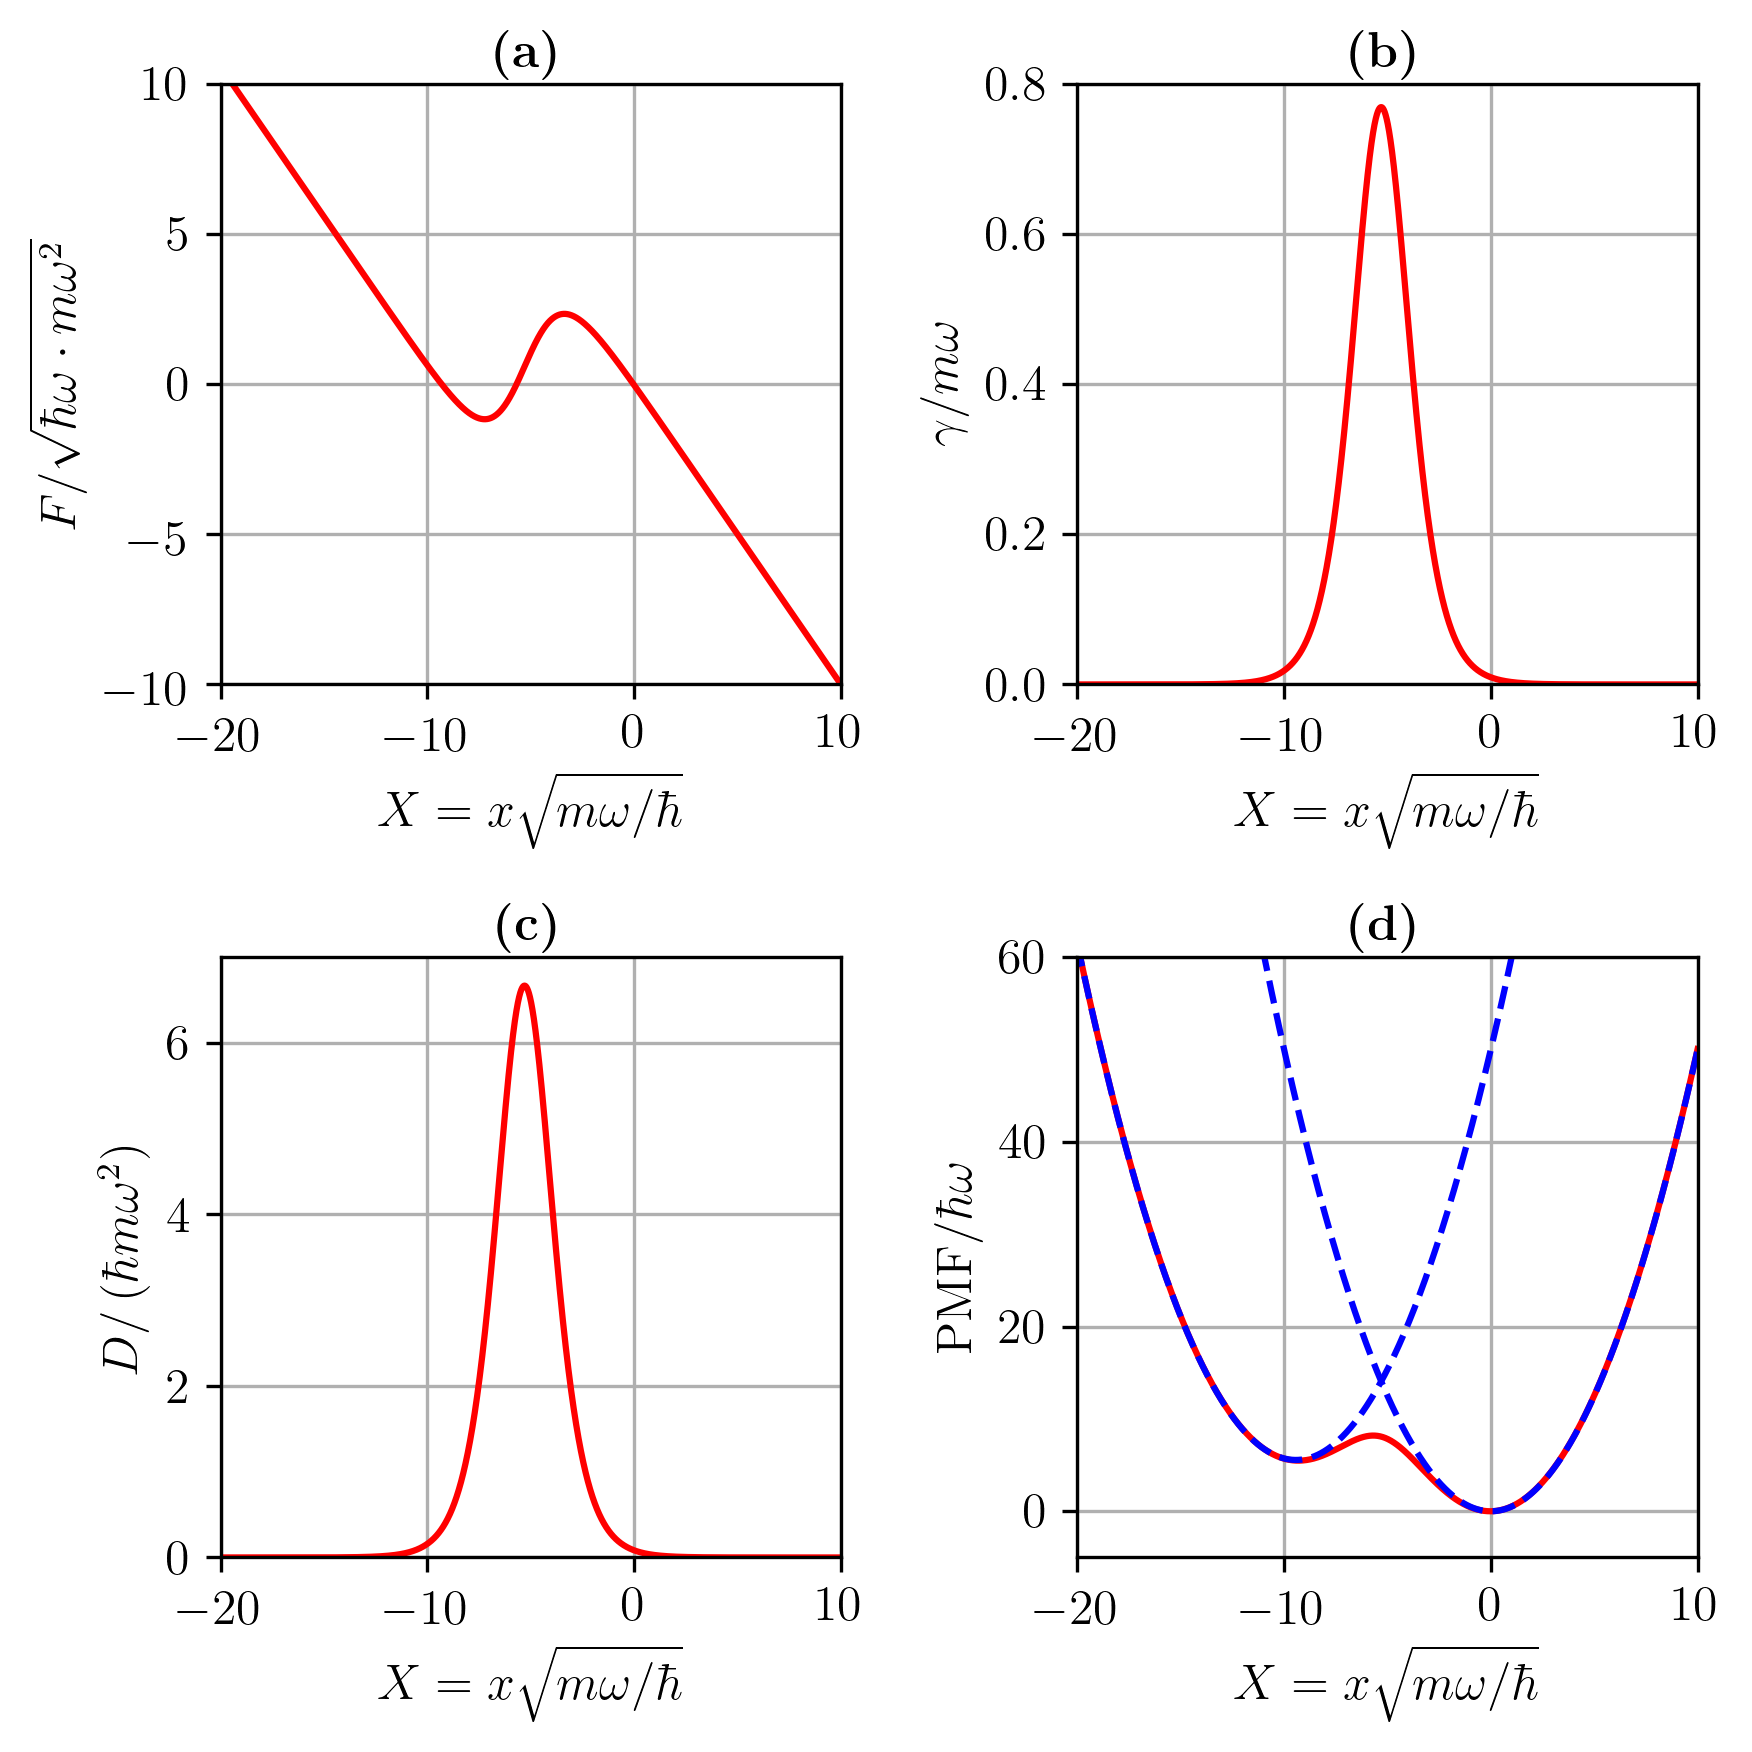

In [21]:
fig = pyplot.figure(figsize=(6, 6), tight_layout=True)
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)

#[98500:101500]

def plot_axes(ax, data, label):
    ax.plot(grid[1900000:2100000], data[1900000:2100000], c="r")
    ax.set_xlabel("$X=x\\sqrt{m\\omega/\\hbar}$")
    ax.set_ylabel(label)
    ax.set_xlim(-20, 10)
    #ax.set_xticks([-40, -20, 0, 20, 40])
    #ax.set_ylim(-200, 200)
    #ax.set_yticks([-40, -20, 0, 20, 40])
    ax.grid()
    #ax1.text(-5., 1., "\\textbf{(a)}", ha="center", va="bottom")

plot_axes(ax1, force / omega, "$F/\\sqrt{\\hbar\\omega\\cdot m\\omega^2}$")
#plot_axes(ax1, force[98500:101500], "$F/\\sqrt{m\\omega/\\hbar}$ [eV]")t

#print(grid[numpy.argmin(numpy.abs(force))])

plot_axes(ax2, gamma, "$\\gamma/m\\omega$")
#plot_axes(ax2, gamma[98500:101500], "$\\hbar\\gamma/m\\omega$ [$\\hbar$]")

plot_axes(ax3, corr / omega, "$D/\\left(\\hbar m\\omega^2\\right)$")
#plot_axes(ax3, corr[98500:101500], "$\\hbar D/m\\omega$ [$\\hbar\\cdot\\mathrm{eV}$]")

plot_axes(ax4, pmf, "PMF$/\\hbar\\omega$")
#ax4.plot(grid, pmf, "r")
ax4.plot(grid, .5 * grid**2, "--b")
ax4.plot(grid, .5 * grid**2 + epsilon/omega + numpy.sqrt(2)*lamda/omega * grid, "--b")

ax1.set_title("\\textbf{(a)}", fontdict={"fontsize":"medium"}, pad=4)
ax1.set_ylim(-10., 10.)
ax2.set_title("\\textbf{(b)}", fontdict={"fontsize":"medium"}, pad=4)
ax2.set_ylim(.0, .8)
ax3.set_title("\\textbf{(c)}", fontdict={"fontsize":"medium"}, pad=4)
ax3.set_ylim(.0, 7.)
ax4.set_title("\\textbf{(d)}", fontdict={"fontsize":"medium"}, pad=4)
ax4.set_ylim(-5., 60.)


pyplot.gcf().set_dpi(300)
pyplot.savefig("SL_1cl.pdf")
pyplot.show()

## Analyze purely quantum system

In [45]:
omega = omega
lamda = lamda
epsilon = epsilon
Gamma = Gamma
T = T
voltage = 0.0

for N in [10, 15, 20, 25]:
    a_op = numpy.diag(numpy.sqrt(numpy.arange(1, N)), k=1)
    a_dag = numpy.transpose(a_op)

    solver = bmme.create_holstein_solver(epsilon, omega, lamda, N, Gamma, -.5*voltage, .5*voltage, T, T, use_exp=True, include_digamma=False)
    rho_ss, L = solver.find_steady_state()
    #numpy.save(f"data/SL_1cl/rho_ss_N={N}.npy", rho_ss)
    #rho_ss = numpy.load(f"data/SL_1cl/rho_ss_N={N}.npy")

    #print(rho_ss)

    #print(solver.d_ops[0])

    pt = bmme.partial_trace(rho_ss, 2).real
    
    print(f"N={N}")
    
    #print(numpy.array_str(pt, precision=3, suppress_small=True))
    print("Etot:         " + str(numpy.trace((a_dag @ a_op + 0.5 * numpy.identity(N)) @ pt)))
    print("Etot: (check) " + str(0.5 * numpy.trace((a_dag @ a_op + a_op @ a_dag) @ pt)))
    print("Epot:         " + str(0.25 * numpy.trace((a_dag + a_op) @ (a_dag + a_op) @ pt)))
    print("Epot: (check) " + str(0.25 * numpy.trace((a_op @ a_dag + a_dag @ a_op) @ pt)))
    print("Ekin:         " + str(-0.25 * numpy.trace((a_dag - a_op) @ (a_dag - a_op) @ pt)))
    print("Ekin: (check) " + str(0.25 * numpy.trace((a_op @ a_dag + a_dag @ a_op) @ pt)))
    print("Trace:        " + str(numpy.trace(pt)), end="\n\n\n\n")

N=10
Etot:         4.06875615296512
Etot: (check) 3.7869945320688325
Epot:         1.893497266034417
Epot: (check) 1.8934972660344163
Ekin:         1.8934972660344154
Ekin: (check) 1.8934972660344163
Trace:        1.0



N=15
Etot:         5.446997329632878
Etot: (check) 5.249518609421756
Epot:         2.6247593047108775
Epot: (check) 2.624759304710878
Ekin:         2.6247593047108775
Ekin: (check) 2.624759304710878
Trace:        0.9999999999999999



N=20
Etot:         6.466628839991059
Etot: (check) 6.3315031409911855
Epot:         3.1657515704955914
Epot: (check) 3.1657515704955927
Ekin:         3.165751570495594
Ekin: (check) 3.1657515704955927
Trace:        1.0



N=25
Etot:         7.196699571114767
Etot: (check) 7.106219526276252
Epot:         3.5531097631381243
Epot: (check) 3.553109763138126
Ekin:         3.5531097631381283
Ekin: (check) 3.553109763138126
Trace:        1.0000000000000002





In [10]:
omega = omega
lamda = lamda
epsilon = epsilon
Gamma = Gamma
T = T
voltage = 0.0

for N in [55, 60, 65, 70]:
    a_op = numpy.diag(numpy.sqrt(numpy.arange(1, N)), k=1)
    a_dag = numpy.transpose(a_op)

    #solver = bmme.create_holstein_solver(epsilon, omega, lamda, N, Gamma, -.5*voltage, .5*voltage, T, T, use_exp=True, include_digamma=False)
    #rho_ss, L = solver.find_steady_state()
    #numpy.save(f"data/SL_1cl/rho_ss_N={N}.npy", rho_ss)
    rho_ss = numpy.load(f"data/SL_1cl/rho_ss_N={N}.npy")

    #print(rho_ss)

    #print(solver.d_ops[0])

    pt = bmme.partial_trace(rho_ss, 2).real
    
    print(f"N={N}")
    
    #print(numpy.array_str(pt, precision=3, suppress_small=True))
    print("Etot:         " + str(numpy.trace((a_dag @ a_op + 0.5 * numpy.identity(N)) @ pt)))
    print("Etot: (check) " + str(0.5 * numpy.trace((a_dag @ a_op + a_op @ a_dag) @ pt)))
    print("Epot:         " + str(0.25 * numpy.trace((a_dag + a_op) @ (a_dag + a_op) @ pt)))
    print("Epot: (check) " + str(0.25 * numpy.trace((a_op @ a_dag + a_dag @ a_op) @ pt)))
    print("Ekin:         " + str(-0.25 * numpy.trace((a_dag - a_op) @ (a_dag - a_op) @ pt)))
    print("Ekin: (check) " + str(0.25 * numpy.trace((a_op @ a_dag + a_dag @ a_op) @ pt)))
    print("Trace:        " + str(numpy.trace(pt)), end="\n\n\n\n")

N=55
Etot:         8.579669205382194
Etot: (check) 8.573761218256665
Epot:         4.286880609128288
Epot: (check) 4.286880609128333
Ekin:         4.286880609128376
Ekin: (check) 4.286880609128333
Trace:        0.9999999999999998



N=60
Etot:         8.617133963610268
Etot: (check) 8.61351704030615
Epot:         4.306758520153109
Epot: (check) 4.306758520153075
Ekin:         4.306758520153038
Ekin: (check) 4.306758520153075
Trace:        1.0000000000000002



N=65
Etot:         8.640309539653511
Etot: (check) 8.638109860883153
Epot:         4.319054930441573
Epot: (check) 4.319054930441577
Ekin:         4.319054930441579
Ekin: (check) 4.319054930441577
Trace:        1.0



N=70
Etot:         8.654529388527736
Etot: (check) 8.653199289139188
Epot:         4.326599644569568
Epot: (check) 4.326599644569594
Ekin:         4.326599644569618
Ekin: (check) 4.326599644569594
Trace:        1.0





## Plot Wigner function

In [26]:
def wigner(n):
    c = numpy.zeros(n+1)
    c[n] = 1
    return lambda x,p: (-1)**n * numpy.exp(-(x**2 + p**2)) * numpy.polynomial.laguerre.Laguerre(c)(2*(p**2 + x**2))

4.165661125188038 +- 3.973544060619107e-06


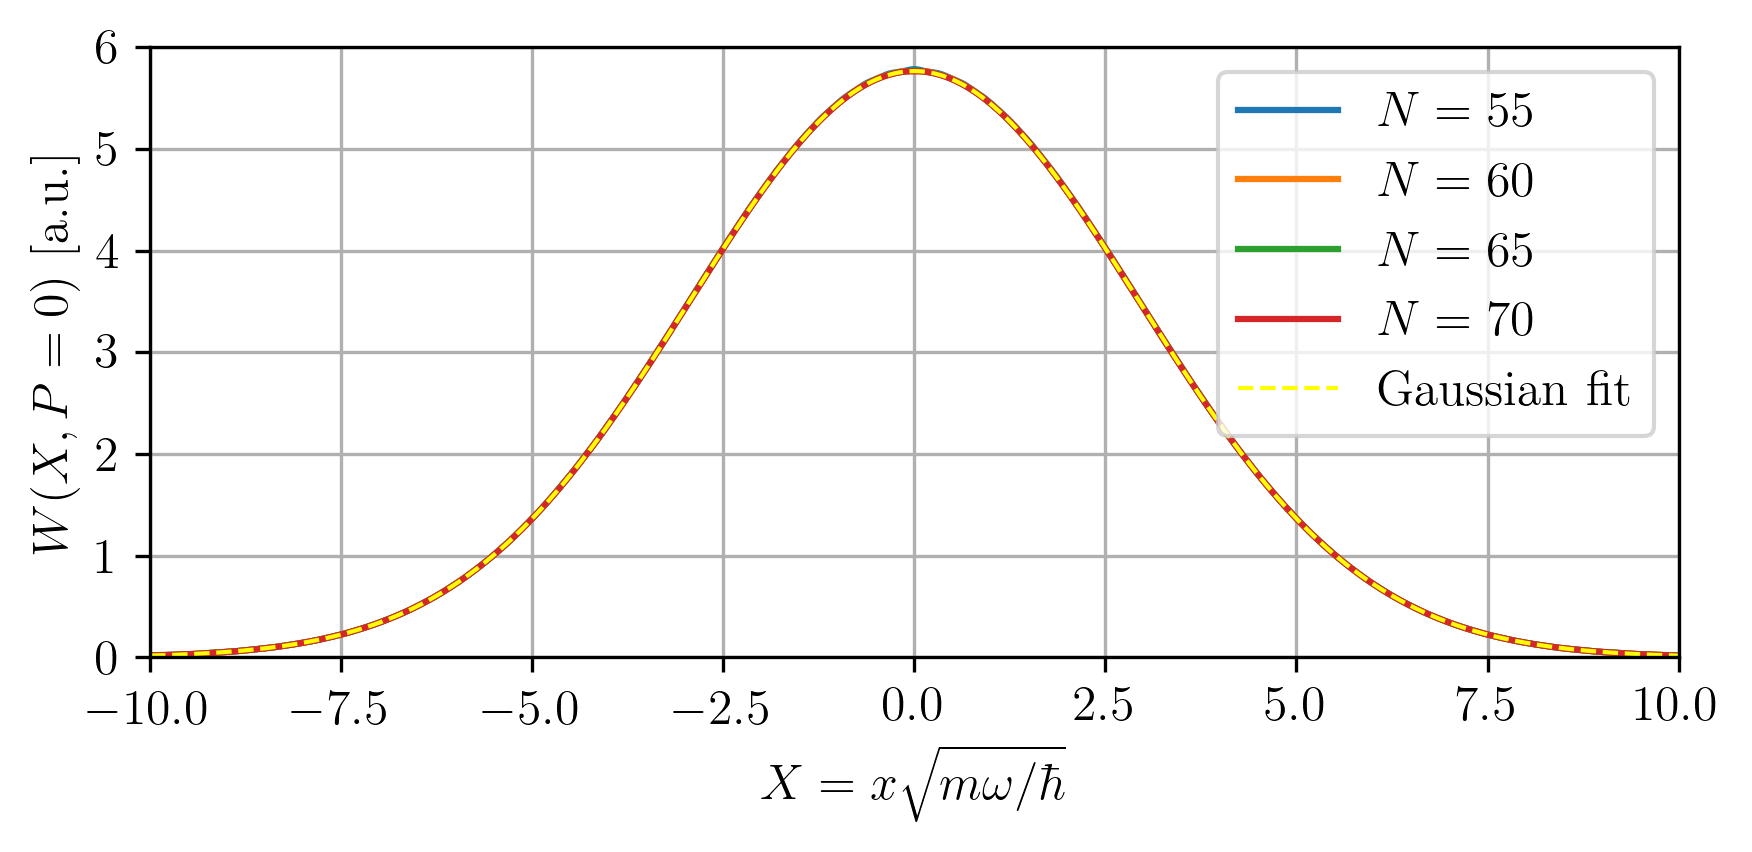

In [32]:
#N = 70
#rho_ss = numpy.load(f"data/SL_1cl/rho_ss_N={N}.npy")
#pt = bmme.partial_trace(rho_ss, 2).real
#vals = numpy.diag(pt)

def my_func(x, p):
    for i, val in enumerate(vals):
        if i == 0:
            result = val * wigner(i)(x, p)
        else:
            result += val * wigner(i)(x, p)
    return result

def gaussian(x, a, b):
    return numpy.exp(-x**2 / b**2) * a

test_x = numpy.linspace(-10, 10, 10001)
#test_70 = my_func(test_x, 0)

#pyplot.plot(test_x, numpy.exp(-test_x**2))

fig = pyplot.figure(figsize=(6, 3), tight_layout=True)
ax = fig.add_subplot(1, 1, 1)

#ax.plot(test_x, 100*test_25, label="$N=25$")
#ax.plot(test_x, 100*test_30, label="$N=30$")
#ax.plot(test_x, 100*test_35, label="$N=35$")
#ax.plot(test_x, 100*test_40, label="$N=40$")
ax.plot(test_x, 100*test_55, label="$N=55$")
ax.plot(test_x, 100*test_60, label="$N=60$")
ax.plot(test_x, 100*test_65, label="$N=65$")
ax.plot(test_x, 100*test_70, label="$N=70$")

popt, pcov = optimize.curve_fit(gaussian, test_x, 100*test_70)
perr = numpy.sqrt(numpy.diag(pcov))
pyplot.plot(test_x, gaussian(test_x, *popt), "--", c="#ffff00", alpha=1, lw=1, label="Gaussian fit")
print(popt[1], "+-", perr[1])

ax.grid()
ax.set_xlim(-10, 10)
ax.set_ylim(0, 6)
ax.set_xlabel("$X=x\\sqrt{m\\omega/\\hbar}$")
ax.set_ylabel("$W(X,P=0)$ [a.u.]")
ax.legend()

pyplot.gcf().set_dpi(300)
pyplot.savefig("SL_1cl_wigner.pdf")
pyplot.show()

## Run trajectories

In [38]:
def my_func2():
    return solve_mbaoab(-9.3090, 0, 100000)
    #return solve_mbaoab(-0.0305, 0, 100000)
    #return solve_mbaoab(numpy.random.normal(scale=4.165661), numpy.random.normal(scale=4.165661), 100000)

for i in range(1, 10):

    results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func2)() for i in enumerate(tqdm(numpy.arange(1000))))
    numpy.save(f"data/SL_1cl/trajectories_rand_x=-9-{i}.npy", numpy.array(results))
    del results
    gc.collect()

#initial = -5
#results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func2)(initial) for i in enumerate(tqdm(numpy.arange(1000))))
#numpy.save("data/SL_1cl/trajectories" + str(initial) + "_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array(results))

#initial = -6
#results = joblib.Parallel(n_jobs=4)(joblib.delayed(my_func2)(initial) for i in enumerate(tqdm(numpy.arange(100))))
#numpy.save("data/SL_1cl/trajectorieslong" + str(initial) + "_" + str(lamda) + "_voltage_" + str(voltage) + ".npy", numpy.array(results))

## Plot trajectories

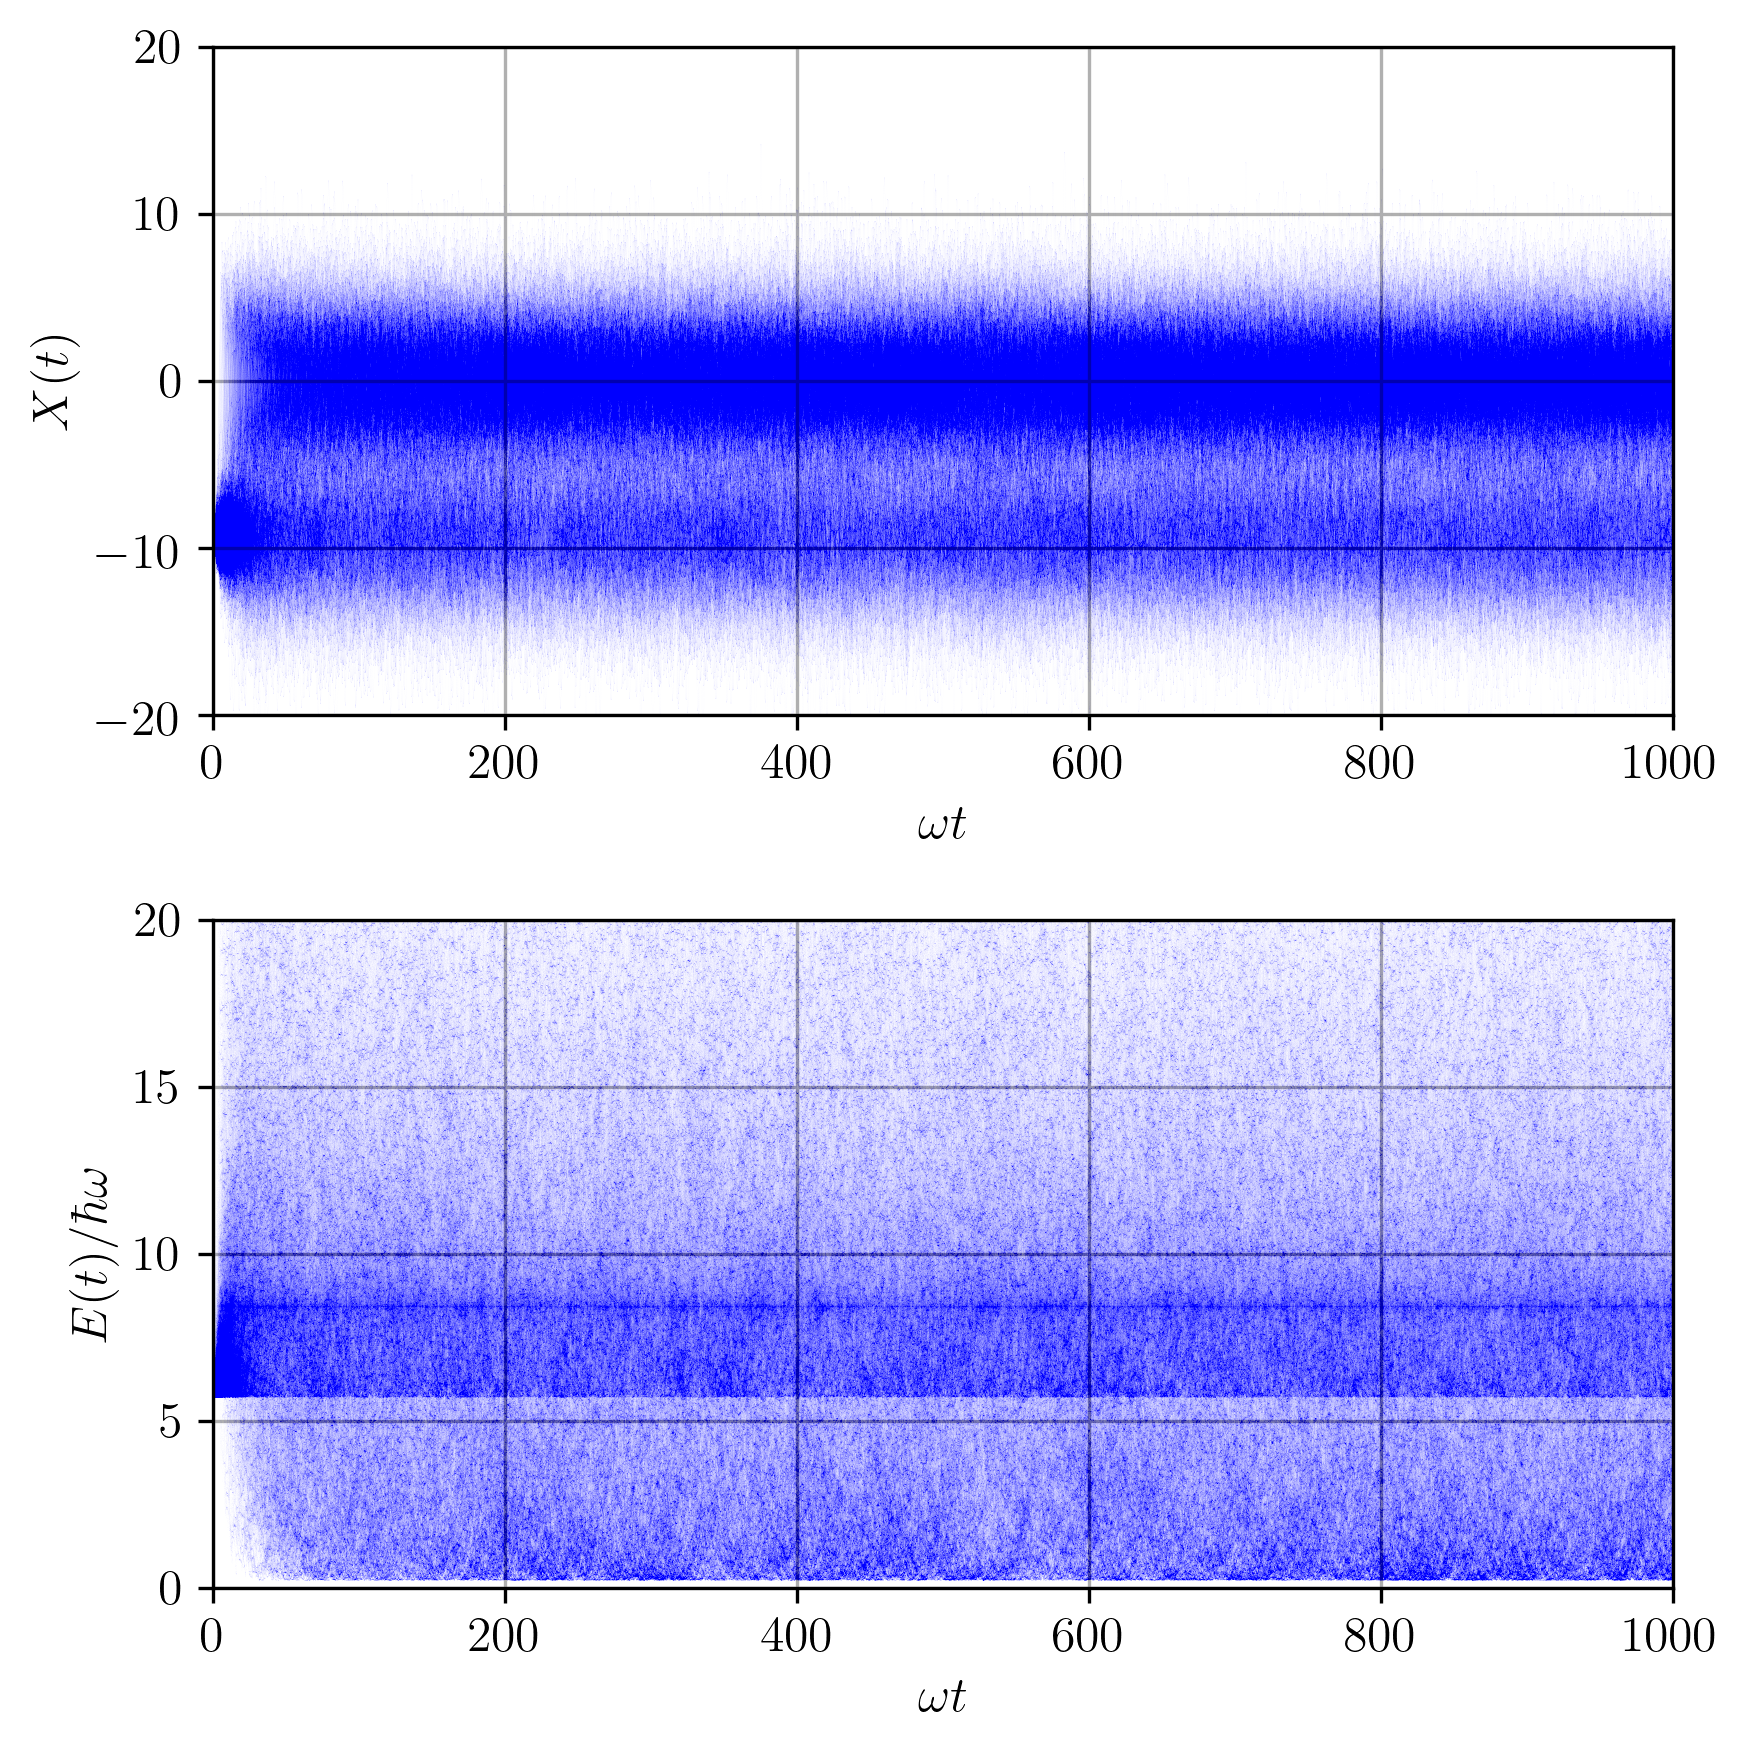

164413

In [14]:
trajectories = numpy.load("data/SL_1cl/trajectories_rand_x=-9.npy")

fig = pyplot.figure(figsize=(6, 6), tight_layout=True)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

for i in tqdm(range(trajectories.shape[0])):
    x_sol = trajectories[i,0]
    v_sol = trajectories[i,1]
    ax1.plot(numpy.arange(len(x_sol))*1e-2, x_sol, ",b", alpha=0.005)
#    ax.plot(numpy.arange(len(x_sol))*1e-2, get_lin_int(x_sol, pmf), c="red")#, alpha=0.1)
    ax2.plot(numpy.arange(len(x_sol))*1e-2, get_lin_int(x_sol, pmf) + 0.5 * v_sol**2, ",b", alpha=0.005)
#    ax.plot(numpy.arange(len(x_sol))*1e-2, 0.5 * v_sol**2, c="blue")#, alpha=0.1)

ax1.set_xlabel("$\\omega t$")
ax1.set_ylabel("$X(t)$")
ax1.set_xlim(0, 1000)
ax1.set_ylim(-20, 20)
ax1.grid()

ax2.set_xlabel("$\\omega t$")
ax2.set_ylabel("$E(t)/\\hbar\\omega$")
ax2.set_xlim(0, 1000)
ax2.set_ylim(0, 20)
ax2.grid()

pyplot.gcf().set_dpi(300)
pyplot.savefig("SL_1cl_trajectories_x=-9.png")
pyplot.show()

del trajectories
fig.clf()
gc.collect()

## Calculate mean values

In [40]:
E_kins = []
E_pots = []

for i in range(10):
    trajectories = numpy.load(f"data/SL_1cl/trajectories_rand_x=0-{i}.npy")
    distribution = numpy.transpose(trajectories[:,:,50000::1], axes=(0,2,1))
    N = distribution.shape[0] * distribution.shape[1]
    distribution = distribution.reshape((N, 2))
    del trajectories
    gc.collect()

    E_kin = numpy.sum(distribution[:,1]**2) / (2*N)
    E_pot = numpy.sum(get_lin_int(distribution[:,0], pmf)) / N
    
    del distribution
    gc.collect()
    
    E_kins.append(E_kin)
    E_pots.append(E_pot)

E_kins = numpy.array(E_kins)
E_pots = numpy.array(E_pots)

E_kin = numpy.sum(E_kins) / len(E_kins)
u_E_kin = numpy.sqrt(numpy.sum((E_kins - E_kin)**2)) / (len(E_kins) - 1)
E_pot = numpy.sum(E_pots) / len(E_pots)
u_E_pot = numpy.sqrt(numpy.sum((E_pots - E_pot)**2)) / (len(E_pots) - 1)

print(f"Kin. energy: {E_kin:.3f}+-{u_E_kin:.3f}")
print(f"Pot. energy: {E_pot:.3f}+-{u_E_pot:.3f}")
print(f"Tot. energy: {(E_kin+E_pot):.3f}+-{numpy.sqrt(u_E_kin**2 + u_E_pot**2):.3f}")

Kin. energy: 4.344+-0.013
Pot. energy: 5.150+-0.012
Tot. energy: 9.494+-0.018


In [41]:
E_kins = []
E_pots = []

for i in range(10):
    trajectories = numpy.load(f"data/SL_1cl/trajectories_rand_x=-9-{i}.npy")
    distribution = numpy.transpose(trajectories[:,:,50000::1], axes=(0,2,1))
    N = distribution.shape[0] * distribution.shape[1]
    distribution = distribution.reshape((N, 2))
    del trajectories
    gc.collect()

    E_kin = numpy.sum(distribution[:,1]**2) / (2*N)
    E_pot = numpy.sum(get_lin_int(distribution[:,0], pmf)) / N
    
    del distribution
    gc.collect()
    
    E_kins.append(E_kin)
    E_pots.append(E_pot)

E_kins = numpy.array(E_kins)
E_pots = numpy.array(E_pots)

E_kin = numpy.sum(E_kins) / len(E_kins)
u_E_kin = numpy.sqrt(numpy.sum((E_kins - E_kin)**2)) / (len(E_kins) - 1)
E_pot = numpy.sum(E_pots) / len(E_pots)
u_E_pot = numpy.sqrt(numpy.sum((E_pots - E_pot)**2)) / (len(E_pots) - 1)

print(f"Kin. energy: {E_kin:.3f}+-{u_E_kin:.3f}")
print(f"Pot. energy: {E_pot:.3f}+-{u_E_pot:.3f}")
print(f"Tot. energy: {(E_kin+E_pot):.3f}+-{numpy.sqrt(u_E_kin**2 + u_E_pot**2):.3f}")

Kin. energy: 4.335+-0.010
Pot. energy: 5.155+-0.010
Tot. energy: 9.490+-0.014


In [42]:
E_kins = []
E_pots = []

for i in range(10):
    trajectories = numpy.load(f"data/SL_1cl/trajectories_rand-{i}.npy")
    distribution = numpy.transpose(trajectories[:,:,50000::1], axes=(0,2,1))
    N = distribution.shape[0] * distribution.shape[1]
    distribution = distribution.reshape((N, 2))
    del trajectories
    gc.collect()

    E_kin = numpy.sum(distribution[:,1]**2) / (2*N)
    E_pot = numpy.sum(get_lin_int(distribution[:,0], pmf)) / N
    
    del distribution
    gc.collect()
    
    E_kins.append(E_kin)
    E_pots.append(E_pot)

E_kins = numpy.array(E_kins)
E_pots = numpy.array(E_pots)

E_kin = numpy.sum(E_kins) / len(E_kins)
u_E_kin = numpy.sqrt(numpy.sum((E_kins - E_kin)**2)) / (len(E_kins) - 1)
E_pot = numpy.sum(E_pots) / len(E_pots)
u_E_pot = numpy.sqrt(numpy.sum((E_pots - E_pot)**2)) / (len(E_pots) - 1)

print(f"Kin. energy: {E_kin:.3f}+-{u_E_kin:.3f}")
print(f"Pot. energy: {E_pot:.3f}+-{u_E_pot:.3f}")
print(f"Tot. energy: {(E_kin+E_pot):.3f}+-{numpy.sqrt(u_E_kin**2 + u_E_pot**2):.3f}")

Kin. energy: 4.328+-0.015
Pot. energy: 5.142+-0.013
Tot. energy: 9.470+-0.019
